# Pre-Processing of Data

In [1]:
# Misc
import os
import sys
from timeit import default_timer as timer 
import datetime
now = datetime.datetime.now()

# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import welch


# Sanity check for jupyter notebooks
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\gabri\Documents\GitHub\IceClassic\sandbox\content



# [Nenana Ice Classic](https://www.nenanaakiceclassic.com/)
> The Ice Classic is Alaska's greatest guessing game! 
In Nenana during 1917 a group of engineers surveying for the Alaska Railroad bet $800 putting in their guesses when the river would break up. This fun little guessing game has turned into an incredible tradition that has now continued for over 100 years! 
Buy and turn in your $3.00 ticket between February 1st and April 5th to be involved in this long running Alaskan tradition. 

# Motivation 
We want to 
- Predict day of break up
- Predict time of break up
- Create betting strategy
- Have fun


# Loading the dataframe
We have compiled some data that might be useful, the file is available in [Github](https://github.com/iceclassic/sandbox/blob/main/content/Time_series_DATA.txt)

The source and explanation of each column is in the txt.

In [2]:
Data=pd.read_csv('Time_series_DATA.txt',skiprows=149,index_col=0)
# Data=pd.read_csv('https://github.com/iceclassic/sandbox/blob/main/content/Time_series_DATA.txt?raw=true',index_col=0,skiprows=289)

Frist lets add some data that I forgot to add to the merged df that is up on github (later I need to run these cells,export new df, and add the source description of column to new file)

# Compiled Data

In [3]:
Data.index=pd.to_datetime(Data.index)
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41351 entries, 1854-01-01 to 2024-02-06
Data columns (total 26 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Predicted ice thickness [m]                        38563 non-null  float64
 4   Noisy predicted ice thickness [m]                  25762 non-null  float64
 5   Nenana: Rainfall [mm]                              29547 non-null  float64
 6   Nenana: Snowfall [mm]                              19945 non-null  float64
 7   Nenana: Snow depth [mm]                            15984 non-null  float64
 8   Nenana: Mean water temperature [C]                 2418 non-null   fl

# Visualizing the dataframe
The data is a dataframe, with the index a datetime object, so it is very easy to plot specific columns.
I've also added the columns `Data['Days since start of year']`and `Data[Days until break up ]`, that we can use as x-axis to plot the variables in a more convenient way.

Using the command plot in columns that are *sparse* might not work, use scatter, or simply extract column, delete rows without data `Data['colname'].dropna()` and re-define index as datetime object (
`Data.index=pd.to_datetime(Data.index)`)

### Temperature Data

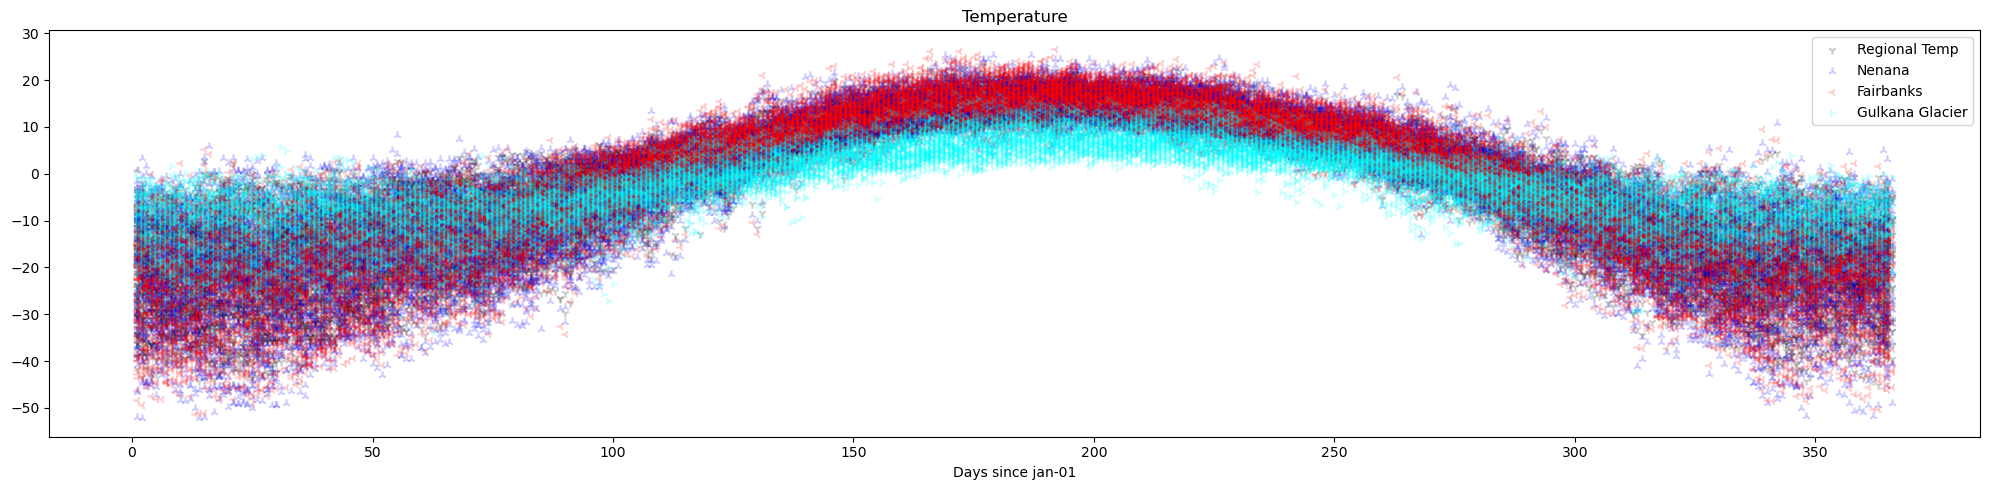

In [9]:
fig, ax1 = plt.subplots(1,1,figsize=(20,5)) 
plt.scatter(Data['Days since start of year'],Data['Regional: Air temperature [C]'],color='k',marker='1',alpha=0.2,label='Regional Temp')
plt.scatter(Data['Days since start of year'],Data['Nenana: Air temperature [C]'],color='b',marker='2',alpha=0.2,label='Nenana')
plt.scatter(Data['Days since start of year'],Data['Fairbanks: Air Temperature [C]'],color='r',marker='3',alpha=0.2,label='Fairbanks')
plt.scatter(Data['Days since start of year'],Data[' Gulkana Temperature [C]'],color='cyan',marker='4',alpha=0.2,label='Gulkana Glacier')
plt.legend()
plt.xlabel('Days since jan-01')
plt.title("Temperature")
plt.tight_layout()
plt.show()

What we learn:
- Temperature in Nenana is very similar to Fairbanks and regional measurements from  a 1$ \degree $ grid. We assume no microclimate near the tripod, at least in terms of temperature.
- Temperature in Gulkana glaciers is different, which is obvious as it is over 1500m and 200km south-west. The direct effects on the ice near Nenana will be negligible, but it might be useful to explore the effects in the melting of the glacier (see columns 20-23 ) and discharge.
- Lets ignore `Nenana` and `Fairbanks`temperatures time series and work instead with `Regional: Air temperature [C]'`, as it has more data. 


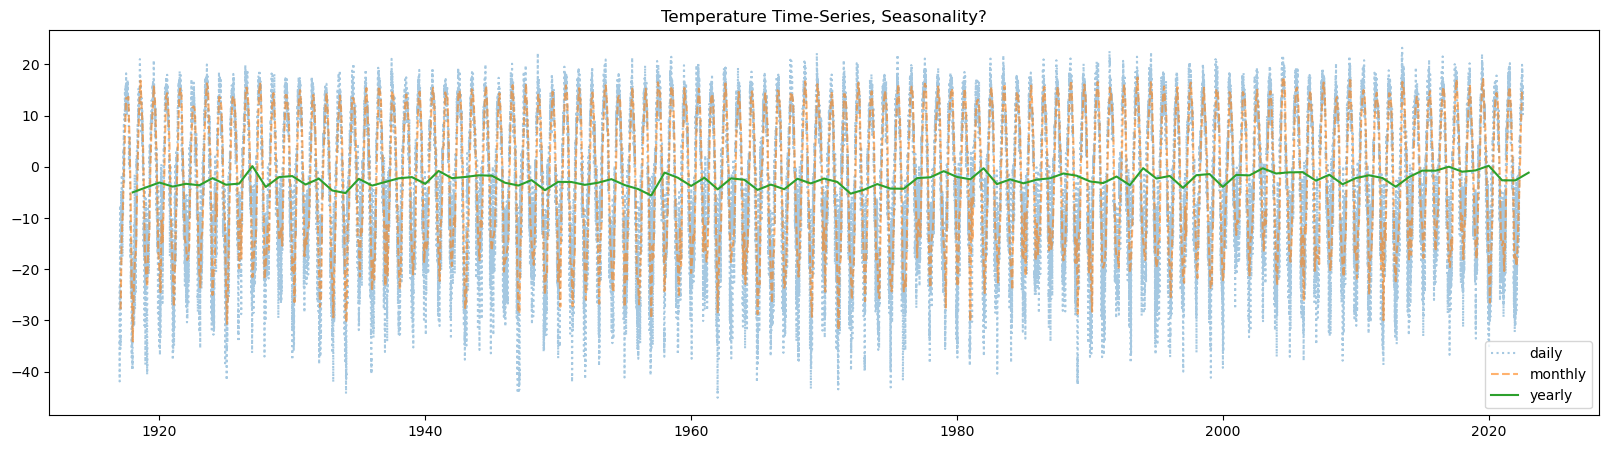

In [5]:
fig, ax1 = plt.subplots(1,1,figsize=(20,5)) 
plt.plot(Data['Regional: Air temperature [C]'],label='daily',alpha=0.4,linestyle='dotted')
plt.plot(Data['Regional: Air temperature [C]'].resample('M').mean().dropna(),label='monthly',alpha=0.6,linestyle='dashed')
plt.plot(Data['Regional: Air temperature [C]'].resample('Y').mean().dropna(),label='yearly')
plt.title('Temperature Time-Series, Seasonality?')
plt.legend()
plt.show()

At a glance, there does not seem to be any overarching growing trend,  or frequency component (besides the normal seasonal variation). A more detailed analysis might reveal other trends (from PSD), but for our purpose we will disregard them, and assume the time-series is stationary.

But we know that there are global oscillation that impact the weather, such as, ENSO, PDO and AO. 

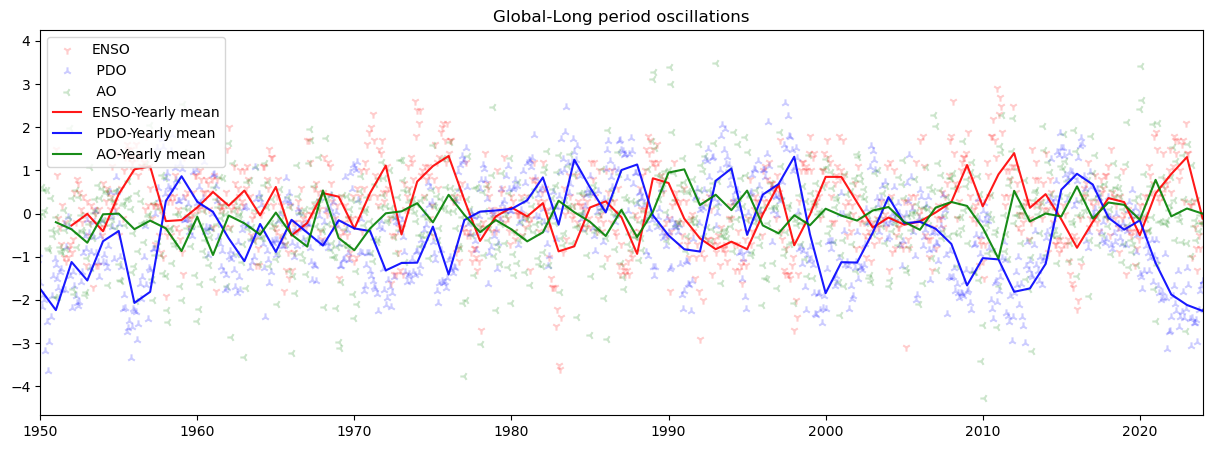

In [6]:
ENSO=Data['Global: ENSO-Southern oscillation index'].copy().resample('Y').mean().dropna()
ENSO.index=pd.to_datetime(ENSO.index)
PDO=Data['Global: Pacific decadal oscillation index'].copy().resample('Y').mean().dropna()
PDO.index=pd.to_datetime(PDO.index)
AO=Data['Global: Artic oscillation index'].copy().resample('Y').mean().dropna()
AO.index=pd.to_datetime(AO.index)
fig, ax1 = plt.subplots(1,1,figsize=(15,5)) 

plt.scatter(Data.index,Data['Global: ENSO-Southern oscillation index'],label='ENSO',alpha=0.2,marker='1',color='r')
plt.scatter(Data.index,Data['Global: Pacific decadal oscillation index'],label=' PDO',alpha=0.2,marker='2',color='b')
plt.scatter(Data.index,Data['Global: Artic oscillation index'],label=' AO',alpha=0.2,marker='3',color='g')

plt.plot(ENSO,label='ENSO-Yearly mean',alpha=0.9,color='r')
plt.plot(PDO,label=' PDO-Yearly mean',alpha=0.9,color='b')
plt.plot(AO,label=' AO-Yearly mean',alpha=0.9,color='g')
plt.title('Global-Long period oscillations')
plt.xlim([pd.to_datetime('1950-01-01'),pd.to_datetime('2024-01-01')])
plt.legend(loc='upper left')
plt.show()

Quantify impact of the values of the index? in Temp?? Rainfall? SnowFall? Maybe sensitivity analysis. Regional  temperature data does not seem to exhibit a lot of multi-year oscillation, therefore the impact of the global scale trend in regional (check for local by simply plotting the time-series ofr `Nenana: Air Temperature`) is small.

### Ice Thickness
We have ice thickness measurement from the last 30 years, but the frequency of the measurements  is not very good (around 15 data-points from jan-01 to break up of every year).

We can use our temperature time-series to make a very rudimentary prediction of the ice-growth using Ashton's formula ( see detail in column description)

(0.0, 150.0)

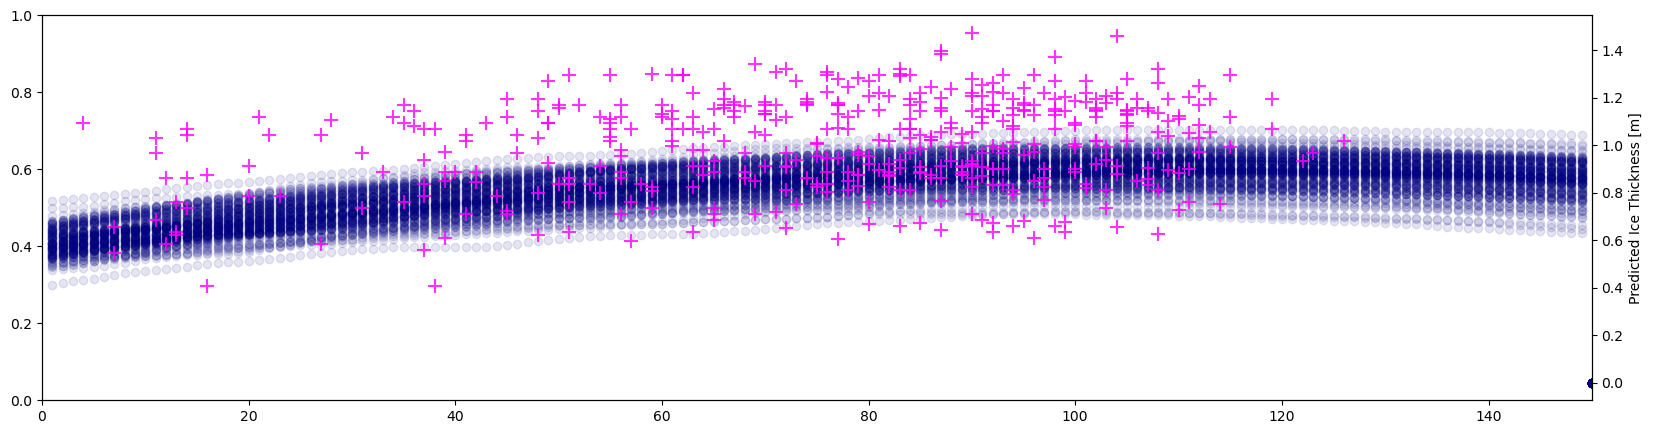

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax = ax.twinx()
ax.scatter(Data['Days since start of year'],Data['Predicted ice thickness [m]'], color="navy", alpha=0.1, label='Predicted ice thickness+ synthetic noise')
ax.scatter(Data['Days since start of year'],Data["IceThickness [cm]"]/100, color="magenta", alpha=0.8, label='Measured ice thickness',marker='+',s=100)
ax.set_ylabel('Predicted Ice Thickness [m]')

ax.set_xlim([0,150])



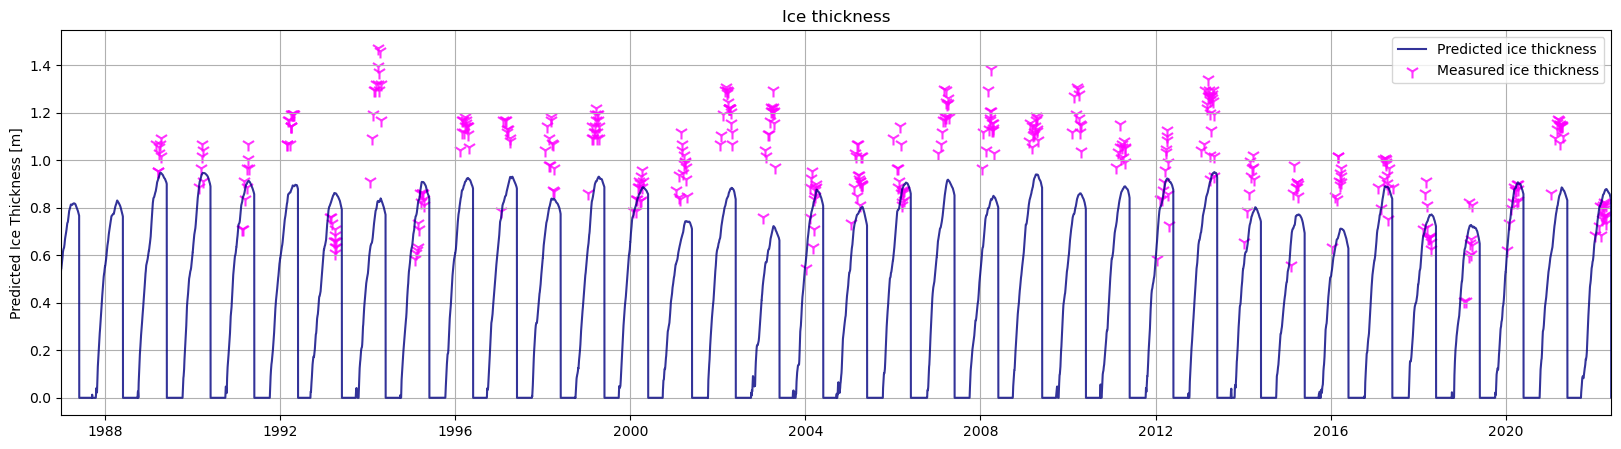

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
# Scatter plot for air temperature

ax.set_title('Ice thickness')
ax.grid(True)

ax.plot(Data['Predicted ice thickness [m]'], color="navy", alpha=0.8, label='Predicted ice thickness')
ax.scatter(Data.index,Data["IceThickness [cm]"]/100, color="magenta", alpha=0.8, label='Measured ice thickness',marker='1',s=100)
ax.set_ylabel('Predicted Ice Thickness [m]')
ax.set_xlim([pd.to_datetime('1987-01-01'),pd.to_datetime('2022-06-01')])
ax.legend()


# Show plot
plt.show()


Waht we learned:
- The prediction seem adequate (compute GOF metrics) for our purpose of *data augmentation*  of ice thickness data. It is a very simple model, with a few simplification and assumption (see column description), but at least its a good first approach.
- Our model, does a reasonably good job of estimating ice-growth, but a very bad job at estimating ice-melting, if we just use the ODE to estimate ice thickness, the ice does not melt through summer, and carries on to the next winter, accumulating. This is probably due to the ice breaking-up and then melting instead of it breaking up, when it has melted. We had to force zero ice thickness in the summer to achieve reasonable result ( again see column description for more info)
- Ice break up, depends on more that just temperature and ice-thickness
